In [1]:
import graph_load
import graph_model
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, f1_score, roc_curve, RocCurveDisplay, auc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda'
#data_dir = './tnf/'
data_dir = './yfp/'


In [3]:
def test(test_loader, model):
    model.eval()
    pred_all = []
    target_all = []
    out_all = []

    with torch.no_grad():
        for data in test_loader:
            data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            out_all.append(out)
            #pred = out.argmax(dim=1)
            #pred_all.append(pred)
            target_all.append(data.y)

        out_all = torch.cat(out_all, dim=0)
        #pred_all = torch.cat(pred_all, dim=0)
        target_all = torch.cat(target_all, dim=0)

    return target_all, out_all

print(f"Test acc: {accuracy_score(target_test.cpu(), pred_test.cpu())}")
print(f"Test prec: {precision_score(target_test.cpu(), pred_test.cpu())}")
print(f"Test rec: {recall_score(target_test.cpu(), pred_test.cpu())}")
print(f"Test F1: {f1_score(target_test.cpu(), pred_test.cpu())}")  
print(f"Test F2: {fbeta_score(target_test.cpu(), pred_test.cpu(), beta=2.0)}")
print(f"Total: {target_test.cpu().shape}, total positive: {target_test.cpu().sum()}")
print(f"Wrongly predicted: {wrong_pred}, wrongly predicted positive: {wrong_pos}") 


In [4]:
targets = []
outs = []
preds = []
for split in range(5):
    model = graph_model.GCNMid().to(device)
    #train_loader, val_loader, test_loader = graph_load.LoadGraphData(data_dir, 256, 256, split)
    test_loader = graph_load.TestData(data_dir, 256)
    model.cuda()
    model.load_state_dict(torch.load(f'./8-20_split_{split}.pt'))
    target_test, out_test = test(test_loader, model)
    _, pred_test = torch.max(out_test.data, 1)
    out_test = torch.nn.functional.softmax(out_test.data, 1)[:, 1]
    wrong_pos = (target_test * (target_test != pred_test)).sum()
    wrong_pred = ((target_test != pred_test)).sum()
    targets.append(target_test.cpu())
    outs.append(out_test.cpu())
    preds.append(pred_test.cpu())

In [80]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

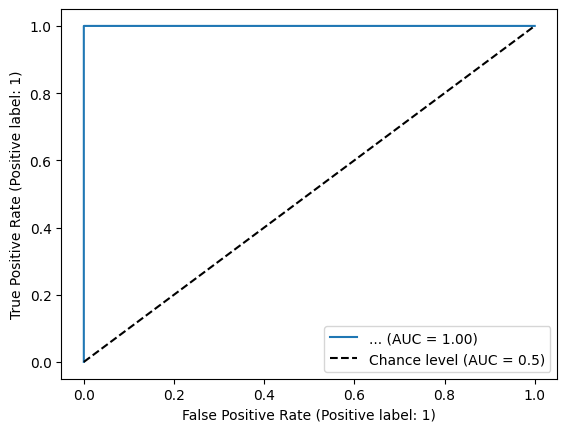

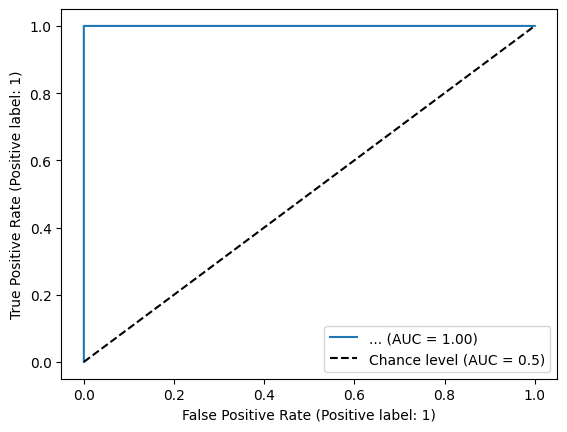

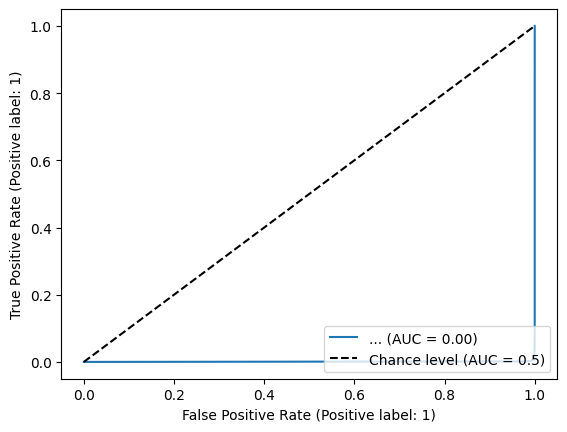

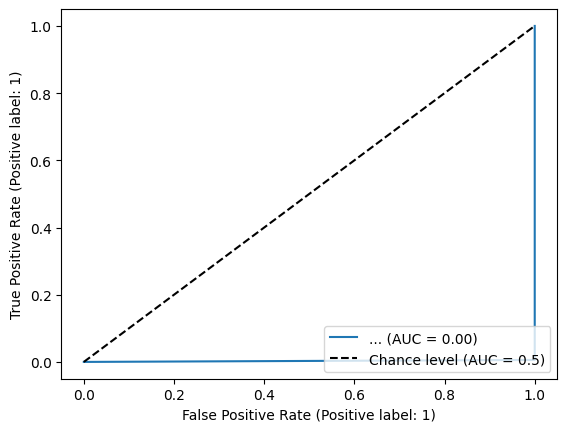

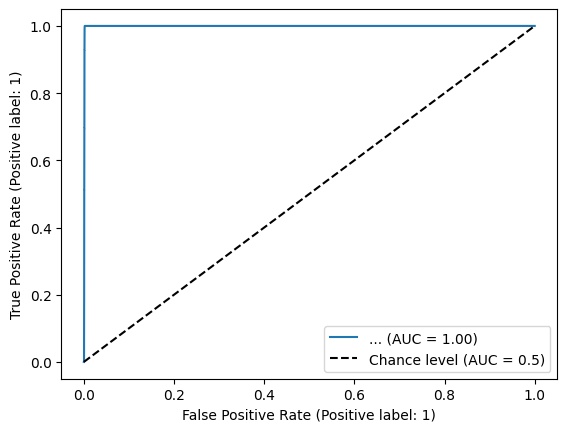

In [81]:
for split in range(5):
    display = RocCurveDisplay.from_predictions(targets[split], outs[split], name="...", plot_chance_level=True)
    interp_tpr = np.interp(mean_fpr, display.fpr, display.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(display.roc_auc)

In [82]:
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

In [83]:
chance_x = np.linspace(0, 1, 100)
chance_y = np.linspace(0, 1, 100)

In [84]:
mean_tpr

array([0.        , 0.60001508, 0.60003016, 0.60004524, 0.60006031,
       0.60007539, 0.60009047, 0.60010555, 0.60012063, 0.60013571,
       0.60015078, 0.60016586, 0.60018094, 0.60019602, 0.6002111 ,
       0.60022618, 0.60024125, 0.60025633, 0.60027141, 0.60028649,
       0.60030157, 0.60031665, 0.60033172, 0.6003468 , 0.60036188,
       0.60037696, 0.60039204, 0.60040712, 0.60042219, 0.60043727,
       0.60045235, 0.60046743, 0.60048251, 0.60049759, 0.60051266,
       0.60052774, 0.60054282, 0.6005579 , 0.60057298, 0.60058806,
       0.60060313, 0.60061821, 0.60063329, 0.60064837, 0.60066345,
       0.60067853, 0.6006936 , 0.60070868, 0.60072376, 0.60073884,
       0.60075392, 0.600769  , 0.60078407, 0.60079915, 0.60081423,
       0.60082931, 0.60084439, 0.60085947, 0.60087454, 0.60088962,
       0.6009047 , 0.60091978, 0.60093486, 0.60094994, 0.60096501,
       0.60098009, 0.60099517, 0.60101025, 0.60102533, 0.60104041,
       0.60105548, 0.60107056, 0.60108564, 0.60110072, 0.60111

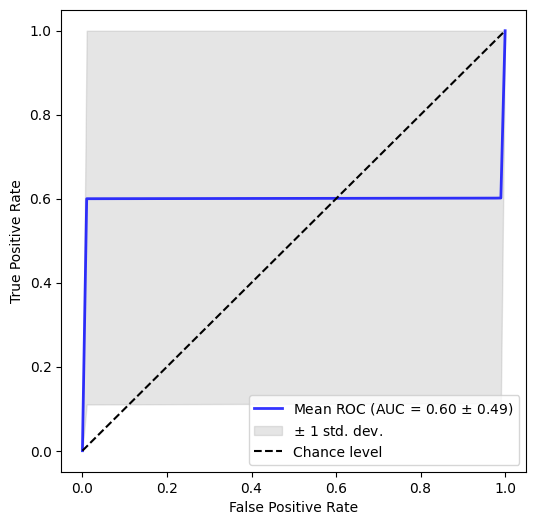

In [85]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.plot(chance_x, chance_y, linestyle='dashed', color='black', label='Chance level')

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()

In [86]:
mean_fpr = np.linspace(0, 1, 100)

In [87]:
tprs.pop(2)

array([0.00000000e+00, 1.62219208e-05, 3.24438416e-05, 4.86657624e-05,
       6.48876831e-05, 8.11096039e-05, 9.73315247e-05, 1.13553446e-04,
       1.29775366e-04, 1.45997287e-04, 1.62219208e-04, 1.78441129e-04,
       1.94663049e-04, 2.10884970e-04, 2.27106891e-04, 2.43328812e-04,
       2.59550733e-04, 2.75772653e-04, 2.91994574e-04, 3.08216495e-04,
       3.24438416e-04, 3.40660337e-04, 3.56882257e-04, 3.73104178e-04,
       3.89326099e-04, 4.05548020e-04, 4.21769940e-04, 4.37991861e-04,
       4.54213782e-04, 4.70435703e-04, 4.86657624e-04, 5.02879544e-04,
       5.19101465e-04, 5.35323386e-04, 5.51545307e-04, 5.67767228e-04,
       5.83989148e-04, 6.00211069e-04, 6.16432990e-04, 6.32654911e-04,
       6.48876831e-04, 6.65098752e-04, 6.81320673e-04, 6.97542594e-04,
       7.13764515e-04, 7.29986435e-04, 7.46208356e-04, 7.62430277e-04,
       7.78652198e-04, 7.94874119e-04, 8.11096039e-04, 8.27317960e-04,
       8.43539881e-04, 8.59761802e-04, 8.75983722e-04, 8.92205643e-04,
      

In [88]:
tprs.pop(2)

array([0.00000000e+00, 5.91698214e-05, 1.18339643e-04, 1.77509464e-04,
       2.36679286e-04, 2.95849107e-04, 3.55018929e-04, 4.14188750e-04,
       4.73358571e-04, 5.32528393e-04, 5.91698214e-04, 6.50868036e-04,
       7.10037857e-04, 7.69207679e-04, 8.28377500e-04, 8.87547321e-04,
       9.46717143e-04, 1.00588696e-03, 1.06505679e-03, 1.12422661e-03,
       1.18339643e-03, 1.24256625e-03, 1.30173607e-03, 1.36090589e-03,
       1.42007571e-03, 1.47924554e-03, 1.53841536e-03, 1.59758518e-03,
       1.65675500e-03, 1.71592482e-03, 1.77509464e-03, 1.83426446e-03,
       1.89343429e-03, 1.95260411e-03, 2.01177393e-03, 2.07094375e-03,
       2.13011357e-03, 2.18928339e-03, 2.24845321e-03, 2.30762304e-03,
       2.36679286e-03, 2.42596268e-03, 2.48513250e-03, 2.54430232e-03,
       2.60347214e-03, 2.66264196e-03, 2.72181179e-03, 2.78098161e-03,
       2.84015143e-03, 2.89932125e-03, 2.95849107e-03, 3.01766089e-03,
       3.07683071e-03, 3.13600054e-03, 3.19517036e-03, 3.25434018e-03,
      

In [89]:
aucs.pop(2)
aucs.pop(2)

0.0029289061607040805

In [90]:
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

In [91]:
mean_tpr

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

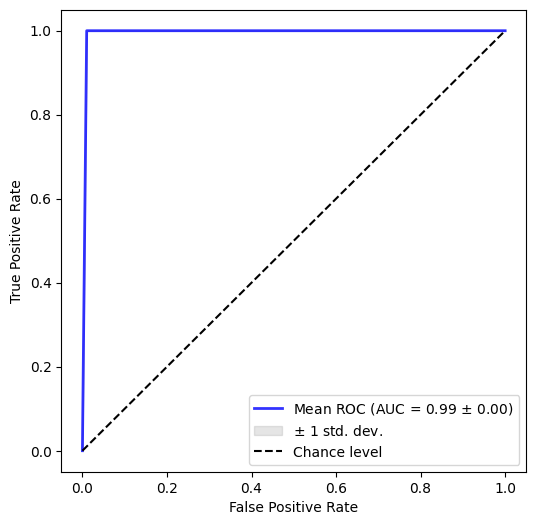

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.plot(chance_x, chance_y, linestyle='dashed', color='black', label='Chance level')

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right")
plt.show()